<a href="https://colab.research.google.com/github/CalebFikes/FHAI/blob/EHR-diffusion/DDPM_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary packages (if using Colab)
%pip install umap-learn
%pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=3187442a69622b9d74e5d403dad3ff5d28340f647bf96a383189b1891f7e78b4
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=43cecf6479af3daf7febafa639673c8f9980c82ab5f6c06f30fe043aac1727b8
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.2 MB/s eta 0:00:00


In [ ]:
# Only run this cell if using colab
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

'''
This script does conditional image generation on Patient Treatment Classification dataset (https://www.kaggle.com/datasets/saurabhshahane/patient-treatment-classification),
using a diffusion model

This code is modified from,
https://github.com/cloneofsimo/minDiffusion

Diffusion model is based on DDPM,
https://arxiv.org/abs/2006.11239

The conditioning idea is taken from 'Classifier-Free Diffusion Guidance',
https://arxiv.org/abs/2207.12598

This technique also features in ImageGen 'Photorealistic Text-to-Image Diffusion Models with Deep Language Understanding',
https://arxiv.org/abs/2205.11487

'''

from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import copy
import torchvision
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score,roc_curve
from umap import UMAP
import plotly.express as px
torch.manual_seed(42)
random.seed(42)


In [5]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2
            return out
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [nn.Linear(in_channels, out_channels), nn.GELU()]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [nn.Linear(in_channels, out_channels), nn.GELU()]

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        # print(x.shape)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding context / time information
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.down1 = UnetDown(n_feat, 2*n_feat)
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)

        self.up0 = nn.Linear(2*n_feat, 2*n_feat)
        self.up1 = UnetUp(4 * n_feat, n_feat)


    def forward(self, x, c, t, context_mask):
        down1 = self.down1(x)

        # convert context to one hot embedding
        c = nn.functional.one_hot(c.long(), num_classes=self.n_classes).type(torch.float)

        # mask out context if context_mask == 1
        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1,self.n_classes)
        context_mask = (-1*(1-context_mask)) # need to flip 0 <-> 1
        c = c * context_mask

        # embed context, time step
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2)


        # could concatenate the context embedding here instead of adaGN
        # hiddenvec = torch.cat((hiddenvec, temb1, cemb1), 1)
        up1 = self.up0(down1)

        # print(up1.shape, down1.shape)
        up2 = self.up1(cemb1*up1+ temb1, down1)  # add and multiply embeddings

        return up2

def ddpm_schedules(beta1, beta2, T):
    """
    Returns pre-computed schedules for DDPM sampling, training process based on linear beta schedule.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"
    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

def cosine_beta_schedule(timesteps, s = 0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype = torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)


class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)
        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        """
        this method is used in training, so samples t and noise randomly
        """

        _ts = torch.randint(1, self.n_T+1, (x.shape[0],)).to(self.device)  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)
        x_t = (
            self.sqrtab[_ts, None] * x
            + self.sqrtmab[_ts, None] * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.
        # dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c)+self.drop_prob).to(self.device)
        # print(noise.shape)
        # return MSE between added noise, and our predicted noise

        return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.n_T, context_mask))

    def sample(self, n_sample, size, device, label= 2, guide_w = 5.0):
        # we follow the guidance sampling scheme described in 'Classifier-Free Diffusion Guidance'
        # to make the fwd passes efficient, we concat two versions of the dataset,
        # one with context_mask=0 and the other context_mask=1
        # we then mix the outputs with the guidance scale, w
        # where w>0 means more guidance

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1), sample initial noise

        c_i = torch.tensor(label).to(device)
        c_i = c_i.repeat(int(n_sample/c_i.shape[0]))

        # don't drop context at test time
        context_mask = torch.zeros_like(c_i).to(device)

        # double the batch
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1. # makes second half of batch context free

        x_i_store = [] # keep track of generated steps in case want to plot something
        print()
        for i in range(self.n_T, 0, -1):
            print(f'sampling timestep {i}',end='\r')
            t_is = torch.tensor([i / self.n_T]).to(device)
            t_is = t_is.repeat(n_sample,1)

            # double batch
            x_i = x_i.repeat(2,1)
            t_is = t_is.repeat(2,1)

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            eps1 = eps[:n_sample]
            eps2 = eps[n_sample:]
            eps = (1+guide_w)*eps1 - guide_w*eps2
            x_i = x_i[:n_sample]
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if i%20==0 or i==self.n_T or i<8:
                x_i_store.append(x_i.detach().cpu().numpy())

        x_i_store = np.array(x_i_store)
        return x_i, x_i_store


class MyDataset(Dataset):
    '''
    Creates a custom torch dataset
    '''
    def __init__(self,x, y):
        self.x =torch.tensor(x.values,dtype=torch.float32)
        self.y =torch.tensor(y.values,dtype=torch.float32)

    def __len__(self):
     return len(self.y)

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]




In [6]:
# Comment the following lines out if NOT using Colab
from google.colab import drive
drive.mount('/content/drive')
filename = '/content/drive/My Drive/data-ori.csv'

# filename = 'data-ori.csv' # Uncomment this line if NOT using colab
data = pd.read_csv(filename)
data['SOURCE'] = data.SOURCE.replace({"in":1, 'out':0}) # refactor treatment status to binary

# Split df into X and y
y = data['SOURCE'] # labels
x = data.drop('SOURCE', axis=1)
x = x.drop('SEX', axis=1)
features = x.columns
print(features)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, shuffle=True, random_state=1)

# Standardize features by removing the mean and scaling to unit variance.
scaler = StandardScaler()
scaler.fit(x_train)
num_feat = x.columns
x_train[num_feat] = scaler.fit_transform(x_train[num_feat]) # fit and transform the train set
x_test[num_feat] = scaler.transform(x_test[num_feat]) # transform the test test

EHR_train = MyDataset(x_train, y_train)
train_labels, train_counts = EHR_train.y.unique(return_counts=True)
print(train_labels, train_counts)

EHR_test = MyDataset(x_test, y_test)
test_labels, test_counts = EHR_test.y.unique(return_counts=True)
print(test_labels, test_counts)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Index(['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE',
       'THROMBOCYTE', 'MCH', 'MCHC', 'MCV', 'AGE'],
      dtype='object')
tensor([0., 1.]) tensor([2110, 1419])
tensor([0., 1.]) tensor([518, 365])


###Test the classifier (Random Forest) on the original dataset

In [7]:
x_test = EHR_test.x
y_test = EHR_test.y
x_train = EHR_train.x
y_train = EHR_train.y

F1 score: 0.5963302752293579
Overall accuracy of random forest on original dataset: 0.7010192525481314


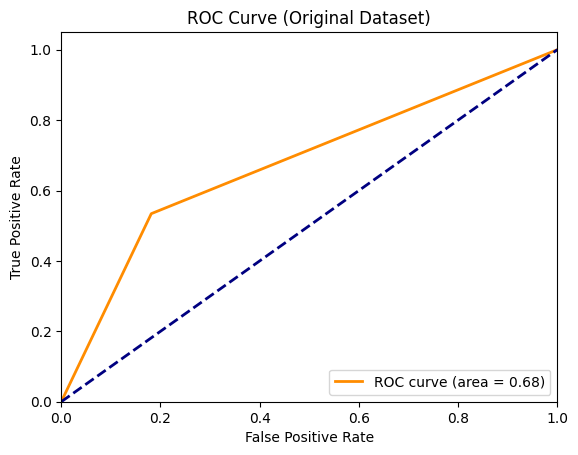

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, ConfusionMatrixDisplay,auc
import matplotlib.pyplot as plt

RF_model = RandomForestClassifier(n_estimators=80, max_depth=3, min_samples_split=20, min_samples_leaf=10)
RF_model.fit(x_train,y_train)
y_pred1 = RF_model.predict(x_test)
acc_1=accuracy_score(y_test, y_pred1)
F1_ensemble=f1_score(y_test, y_pred1)
fpr, tpr, _ = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
print(f'F1 score: {F1_ensemble}')
print(f'Overall accuracy of random forest on original dataset: {acc_1}')


# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Original Dataset)')
plt.legend(loc="lower right")
plt.show()

#### Plot 1 UMAP of original training set

In [11]:
import os

if not os.path.exists("images"):
    os.mkdir("images")

In [12]:
# Plot manifold visualization of original dataset (balanced)
umap_2d = UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap_2d.fit_transform(x_train)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color= y_train.numpy().astype(str), labels={'color': 'Treatment'}, width=800, height=800,
    title='Manifold Projection of Original Balanced Dataset'
)
fig_2d.show()
fig_2d.write_image("images/original_bal_ds_manifold.png")
print(fig_2d)



Figure({
    'data': [{'hovertemplate': 'Treatment=0.0<br>0=%{x}<br>1=%{y}<extra></extra>',
              'legendgroup': '0.0',
              'marker': {'color': '#636efa', 'symbol': 'circle'},
              'mode': 'markers',
              'name': '0.0',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([5.49927  , 2.522053 , 7.581977 , ..., 8.084851 , 7.180511 , 2.8029566],
                         dtype=float32),
              'xaxis': 'x',
              'y': array([3.9785953, 6.442634 , 1.6734269, ..., 2.150451 , 7.3058457, 4.182045 ],
                         dtype=float32),
              'yaxis': 'y'},
             {'hovertemplate': 'Treatment=1.0<br>0=%{x}<br>1=%{y}<extra></extra>',
              'legendgroup': '1.0',
              'marker': {'color': '#EF553B', 'symbol': 'circle'},
              'mode': 'markers',
              'name': '1.0',
              'showlegend': True,
              'type': 'scattergl',
              'x': array

In [ ]:
# Imbalance the dataset manually with this list.
sample_probs = {'0':0.1, '1': 0.9} # key = class label; value = probability of keeping
idx_to_keep = [i for i, label in enumerate(EHR_train.y)  if random.random() > sample_probs[str(int(label.item()))]]
len(idx_to_keep)

2051

### Build imbalanced (imbalanced in terms of labels) training set



In [13]:
# Imbalance dataset manually

EHR_train.x = EHR_train.x[idx_to_keep]
EHR_train.y = EHR_train.y[idx_to_keep]
train_labels, train_counts = EHR_train.y.unique(return_counts=True)
train_labels, train_counts

NameError: ignored

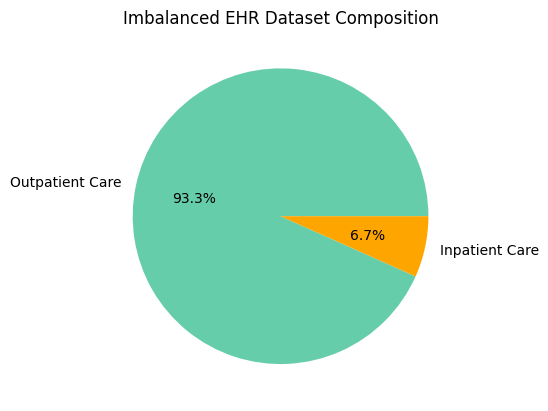

<Figure size 640x480 with 0 Axes>

In [ ]:
# Pie chart visualization of imbalanced dataset
v, c = EHR_train.y.unique(return_counts=True)


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)

plt.pie(c, labels=['Outpatient Care', 'Inpatient Care'], autopct='%1.1f%%', colors=['#66CDAA','orange'])
plt.title('Imbalanced EHR Dataset Composition')
plt.show()
plt.savefig("images/imbalanced_ds_pie.png")


#### Plot 2: UMAP of imbalanced dataset (manually created)

In [ ]:
# manifold visualization of imbalanced dataset
umap_2d = UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap_2d.fit_transform(EHR_train.x)

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color= EHR_train.y.numpy().astype(str), labels={'color': 'Treatment'}, width=800, height=800,
        title='Manifold Projection of Imbalanced Dataset'

)
fig_2d.show()
fig_2d.write_image("images/imbalanced_ds_manifold.png")
print(fig_2d)


Figure({
    'data': [{'hovertemplate': 'Treatment=0.0<br>0=%{x}<br>1=%{y}<extra></extra>',
              'legendgroup': '0.0',
              'marker': {'color': '#636efa', 'symbol': 'circle'},
              'mode': 'markers',
              'name': '0.0',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([4.951729 , 2.9593825, 8.43967  , ..., 3.784836 , 8.304964 , 5.3114405],
                         dtype=float32),
              'xaxis': 'x',
              'y': array([5.1055183, 3.0618474, 4.5155253, ..., 8.58809  , 5.6129556, 2.1064663],
                         dtype=float32),
              'yaxis': 'y'},
             {'hovertemplate': 'Treatment=1.0<br>0=%{x}<br>1=%{y}<extra></extra>',
              'legendgroup': '1.0',
              'marker': {'color': '#EF553B', 'symbol': 'circle'},
              'mode': 'markers',
              'name': '1.0',
              'showlegend': True,
              'type': 'scattergl',
              'x': array

### Train different models on imbalanced training set

In [ ]:
x_test = EHR_test.x
y_test = EHR_test.y
x_train = EHR_train.x
y_train = EHR_train.y

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, ConfusionMatrixDisplay,auc
import matplotlib.pyplot as plt

0.0


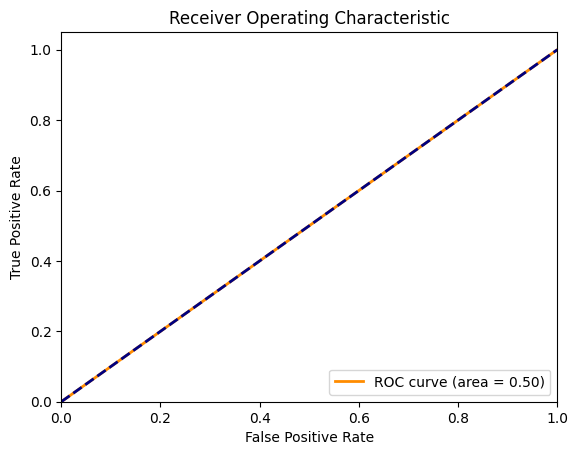

In [ ]:
model1 = RandomForestClassifier(n_estimators=80, max_depth=3, min_samples_split=20, min_samples_leaf=10)

model1.fit(x_train,y_train)
y_pred1 = model1.predict(x_test)


acc_1=accuracy_score(y_test, y_pred1)
F1_ensemble=f1_score(y_test, y_pred1)
fpr, tpr, _ = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
print(F1_ensemble)
# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Evaluation

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = y_test.cpu()


ConfusionMatrixDisplay.from_predictions(
    labels, y_pred)
plt.show()

print(f"Val: Acc={accuracy_score(y_test, clf.predict(x_test)):.3f}, F1={test_f1:.3f}")

fpr, tpr, thresholds = roc_curve(labels, preds)
roc_auc = roc_auc_score(labels, preds)
plt.plot(fpr, tpr, label='ROC (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.title('SMOTED Dataset ROC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right", fontsize=20)
plt.show()
plt.savefig("images/imbalanced_ROC.png")


'from sklearn.metrics import roc_auc_score, f1_score, roc_curve, ConfusionMatrixDisplay\nimport matplotlib.pyplot as plt\nlabels = y_test.cpu()\n\n\nConfusionMatrixDisplay.from_predictions(\n    labels, y_pred)\nplt.show()\n\nprint(f"Val: Acc={accuracy_score(y_test, clf.predict(x_test)):.3f}, F1={test_f1:.3f}")\n\nfpr, tpr, thresholds = roc_curve(labels, preds)\nroc_auc = roc_auc_score(labels, preds)\nplt.plot(fpr, tpr, label=\'ROC (area = %0.2f)\' % (roc_auc))\nplt.plot([0, 1], [0, 1],\'r--\')\nplt.title(\'SMOTED Dataset ROC Curve\')\nplt.xlabel(\'False positive rate\')\nplt.ylabel(\'True positive rate\')\nplt.legend(loc="lower right", fontsize=20)\nplt.show()\nplt.savefig("images/imbalanced_ROC.png")'

In [ ]:
'''import sklearn.metrics as sm
disp = sm.ConfusionMatrixDisplay.from_predictions(labels, preds,
                                 cmap=plt.cm.Blues,
                                  normalize='true', values_format = '%'
                                  )
plt.title('Confusion Matrix (Imbalanced Dataset)')
plt.show()
'''

"import sklearn.metrics as sm\ndisp = sm.ConfusionMatrixDisplay.from_predictions(labels, preds,\n                                 cmap=plt.cm.Blues,\n                                  normalize='true', values_format = '%'\n                                  )\nplt.title('Confusion Matrix (Imbalanced Dataset)')\nplt.show()\n"

###Train DDPM

In [ ]:
# hyperparameters for ddpm
n_epoch = 1000
batch_size = 16
n_T = 75
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_classes = 2
n_feat = 9
lrate = 1e-2
save_model = False
save_dir = './data/diffusion_outputs10/'
w = .2

dataloader = torch.utils.data.DataLoader(EHR_train, batch_size=batch_size, drop_last=True, shuffle=True)
ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=2), \
            betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
ddpm.to(device)

# Implementing EMA here:
ddpm_ema = copy.deepcopy(ddpm)

def ema(source, target, decay):
    source_dict = source.state_dict()
    target_dict = target.state_dict()
    for key in source_dict.keys():
        target_dict[key].data.copy_(
            target_dict[key].data * decay +
            source_dict[key].data * (1 - decay))

optimizer = torch.optim.SGD(ddpm.parameters(), 0.01, 0.7)

# # optionally load a model
# # ddpm.load_state_dict(torch.load("./data/diffusion_outputs/ddpm_unet01_mnist_9.pth"))


pbar = tqdm(dataloader)
loss_ema = True
for epoch in range(n_epoch):
    for x, label in pbar:
        optimizer.zero_grad()
        x = x.to(device)
        label = label.to(device)
        loss = ddpm(x, label)
        loss.backward()
        ema(ddpm, ddpm_ema, 0.95)
        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
        pbar.set_description(f"loss: {loss_ema:.4f}")
        optimizer.step()


loss: 0.9976: 100%|██████████| 128/128 [00:01<00:00, 111.94it/s]


###Generate Samples and Visualize Distribution of Augmented Sample Features

In [ ]:
v, c = EHR_train.y.unique(return_counts=True)

# generate synthetic samples
ddpm.eval()
with torch.no_grad():
    n_sample = np.absolute(c[0]-c[1])
    x_gen, x_gen_store = ddpm.sample(n_sample, (9,), device, label=[1], guide_w=4)

# Use Gaussian kernel density estimate to plot feature distributions for generated and real data
df = pd.DataFrame(x_gen.cpu().numpy(), columns=features) # df is the generated data
fig, axes = plt.subplots(9, 1, figsize=(8, 25))
plt.subplots_adjust(hspace=0.5) # Add vertical spacing
x = pd.DataFrame(EHR_test.x.cpu().numpy(), columns=features) # x is the real data

for i, c in enumerate(num_feat):
    f = df[[c]].plot(kind='kde',color='#2B83BA',ax=axes[i])
    f = x[[c]].plot(kind='kde',color='#D7191C', linestyle='--', ax=axes[i])
    axes[i].legend([f'{c} - Generated', f'{c} - Original'])
    axes[i].set_title(f'Generated and Original Comparision of {c}')

In [ ]:
# augmenting dataset with synthetic samples:
x_train = torch.vstack([EHR_train.x, x_gen.cpu()])
y_train = torch.concatenate([EHR_train.y, torch.ones(x_gen.shape[0])])

# check to make sure augmented properly
y_train.unique(return_counts=True)

In [ ]:
# Plot pie chart of augmented dataset
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)
v, c = torch.unique(y_train, return_counts = True )
plt.pie(c, labels=['Outpatient Care', 'Inpatient Care'], autopct='%1.1f%%', colors=['#66CDAA','orange'])
plt.title('Augmented EHR Dataset Composition')
plt.savefig("images/augmented_ds_pie.png")


In [ ]:
model1 = RandomForestClassifier(n_estimators=80, max_depth=4, min_samples_split=20, min_samples_leaf=10)
model1.fit(x_train,y_train)
y_pred1 = model1.predict(x_test)

print(f' Overall accuracy of random forest classifier trained on augmented dataset {accuracy_score(y_test, y_pred1)}')


In [ ]:
acc_1= accuracy_score(y_test, y_pred1)
F1_ensemble= f1_score(y_test, y_pred1)
fpr, tpr, __ = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
print(F1_ensemble)
# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest trained on Augmented Dataset ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(acc_1)

### Visualize the generated samples by class

In [ ]:

ddpm.eval()

# Generate 1000 samples of each class to check feature distribution
with torch.no_grad():
    n_sample = 2000
    x_gen, x_gen_store = ddpm.sample(n_sample, (9,), device, label=[1], guide_w=0)
df1 = pd.DataFrame(x_gen.cpu().numpy(), columns=features)

with torch.no_grad():
    n_sample = 2000
    x_gen, x_gen_store = ddpm.sample(n_sample, (9,), device, label=[0], guide_w=0)
df0 = pd.DataFrame(x_gen.cpu().numpy(), columns=features)

fig, axes = plt.subplots(9, 1, figsize=(13, 35))
plt.subplots_adjust(hspace=0.5) # Add vertical spacing
x = pd.DataFrame(EHR_train.x.cpu().numpy(), columns=features)
x1 = x.iloc[(y_test==1).nonzero(as_tuple=True)[0],:]
x0 = x.iloc[(y_test==0).nonzero(as_tuple=True)[0],:]

for i, c in enumerate(num_feat):
    df1[[c]].plot(kind='kde', color='#D7191C', linestyle='--', ax=axes[i])
    x1[[c]].plot(kind='kde', color='orange', linestyle='-', ax=axes[i])
    df0[[c]].plot(kind='kde', color='#2B83BA', linestyle='-.', ax=axes[i])
    x0[[c]].plot(kind='kde', color='#66CDAA', linestyle='-', ax=axes[i])
    axes[i].legend([f'{c} - Generated(Inpatient Care)', f'{c} - Original(Inpatient Care)',
                    f'{c} - Generated(Outpatient Care)', f'{c} - Original(Outpatient Care)'])
    axes[i].set_title(f'Generated and Original Comparison of {c} by Class')


#### Plot 3: UMAP of datasets after augmentation

In [ ]:
# manifold visualization of augmented dataset

umap_2d = UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap_2d.fit_transform(x_train)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color= y_train.numpy().astype(str), labels={'color': 'Treatment'}, width=800, height=800,
    title='Manifold Projection of Augmented Dataset'
    )
fig_2d.show()
fig_2d.write_image("images/augmented_bal_ds_manifold.png")
print(fig_2d)


### Testing SMOTE

In [ ]:
# SMOTE implemented w/sklearn package
import torch.utils.data as data_utils
from imblearn.over_sampling import SMOTE
from torch.utils.data import Dataset

smote = SMOTE()
X, y = smote.fit_resample(EHR_train.x.detach().numpy(), EHR_train.y.detach().numpy()) # smote the dataset (ONLY training set)
X_tensor = torch.from_numpy(X) # convert smoted data to tensor
y_tensor = torch.from_numpy(y) # convert labels data to tensor

EHR_train.x = X_tensor
EHR_train.y = y_tensor

In [ ]:
# manifold visualization of SMOTED data
umap_2d = UMAP(n_components=2, init='random', random_state=0,
               n_neighbors=100, negative_sample_rate=200)
proj_2d = umap_2d.fit_transform(EHR_train.x)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color= EHR_train.y.numpy().astype(str), labels={'color': 'Treatment'}, width=800, height=800,
        title='Manifold Projection of SMOTED Dataset'

)
fig_2d.show()
fig_2d.write_image("images/SMOTED_ds_manifold.png")
print(fig_2d)


In [ ]:
# Plot pie chart of SMOTED dataset
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)
v, c = torch.unique(EHR_train.y, return_counts = True )
plt.pie(c, labels=['Outpatient Care', 'Inpatient Care'], autopct='%1.1f%%', colors=['#66CDAA','orange'])
plt.title('SMOTED EHR Dataset Composition')
plt.savefig("images/augmented_ds_pie.png")


In [ ]:
# Train random forest classifier on SMOTED dataset
x_train = EHR_train.x
y_train = EHR_train.y
model1 = RandomForestClassifier(n_estimators=80, max_depth=3, min_samples_split=20, min_samples_leaf=10)
model1.fit(x_train,y_train)
y_pred1 = model1.predict(x_test)
acc_1=accuracy_score(y_test, y_pred1)
F1_ensemble=f1_score(y_test, y_pred1)
fpr, tpr, _ = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
print(F1_ensemble)
# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SMOTED dataset')
plt.legend(loc="lower right")
plt.show()

print(f' Overall accuracy of random forest classifier trained on SMOTED dataset {accuracy_score(y_test, y_pred1)}')